# Defining your own mechanisms such as channels and synapses

`neurax` provides an implementation of the standard Hodgkin-Huxley equations and of glutamatergic synapses. In this tutorial, we will explain how you can define your own mechanisms.

In [1]:
%load_ext autoreload
%autoreload 2

# I have experienced stability issues with float32.
from jax.config import config
config.update("jax_enable_x64", True)
config.update("jax_platform_name", "cpu")

import os
os.environ["XLA_PYTHON_CLIENT_MEM_FRACTION"]=".8"

In [2]:
import time
import matplotlib.pyplot as plt
import numpy as np
import jax
import jax.numpy as jnp
from jax import jit, value_and_grad

import neurax as nx
from neurax.channels import HHChannel
from neurax.synapses import GlutamateSynapse

### Your own channel
Below is how you can define your own channel. We will go into detail about individual parts of the code in the next couple of cells.

In [3]:
from typing import Dict, Optional

import jax.numpy as jnp
from neurax.channels import Channel
from neurax.solver_gate import solve_gate_exponential, solve_inf_gate_exponential

In [4]:

class HHChannel(Channel):
    """Hodgkin-Huxley channel."""

    channel_params = {"gNa": 0.12, "gK": 0.036, "gLeak": 0.0003}
    channel_states = {"m": 0.2, "h": 0.2, "n": 0.2}

    @staticmethod
    def step(u: Dict[str, jnp.ndarray], dt, voltages, params: Dict[str, jnp.ndarray]):
        """Return updated HH channel state and current."""
        ms, hs, ns = u["m"], u["h"], u["n"]
        new_m = solve_gate_exponential(ms, dt, *_m_gate(voltages))
        new_h = solve_gate_exponential(hs, dt, *_h_gate(voltages))
        new_n = solve_gate_exponential(ns, dt, *_n_gate(voltages))

        # Multiply with 1000 to convert Siemens to milli Siemens.
        na_conds = params["gNa"] * (new_m**3) * new_h * 1000  # mS/cm^2
        kd_conds = params["gK"] * new_n**4 * 1000  # mS/cm^2
        leak_conds = params["gLeak"] * 1000  # mS/cm^2

        voltage_term = na_conds + kd_conds + leak_conds

        e_na = 50.0
        e_kd = -77.0
        e_leak = -54.3
        constant_term = na_conds * e_na + kd_conds * e_kd + leak_conds * e_leak

        return {"m": new_m, "h": new_h, "n": new_n}, (voltage_term, constant_term)


def _m_gate(v):
    alpha = 0.1 * _vtrap(-(v + 40), 10)
    beta = 4.0 * jnp.exp(-(v + 65) / 18)
    return alpha, beta


def _h_gate(v):
    alpha = 0.07 * jnp.exp(-(v + 65) / 20)
    beta = 1.0 / (jnp.exp(-(v + 35) / 10) + 1)
    return alpha, beta


def _n_gate(v):
    alpha = 0.01 * _vtrap(-(v + 55), 10)
    beta = 0.125 * jnp.exp(-(v + 65) / 80)
    return alpha, beta


def _vtrap(x, y):
    return x / (jnp.exp(x / y) - 1.0)




def exp_update_alpha(x, y):
    return x / (jnp.exp(x / y) - 1.0)

class Potassium(Channel):
    """Potassium channel."""

    channel_params = {"gK_new": 0.06}
    channel_states = {"n_new": 0.1}

    @staticmethod
    def step(u, dt, voltages, params):
        """Return updated HH channel state and current."""
        ns = u["n_new"]
        alpha = 0.01 * exp_update_alpha(-(voltages + 55), 10)
        beta = 0.125 * jnp.exp(-(voltages + 65) / 80)
        new_n = solve_gate_exponential(ns, dt, alpha, beta)

        # Multiply with 1000 to convert Siemens to milli Siemens.
        kd_conds = params["gK_new"] * new_n**4 * 1000  # mS/cm^2

        e_kd = -77.0        
        current = kd_conds * (e_kd - voltages)

        return {"n_new": new_n}, (jnp.zeros_like(current), current)
    
    
class PotassiumTest(Channel):
    """Potassium channel."""

    channel_params = {"gK_newT": 0.06}
    channel_states = {"n_newT": 0.1}

    @staticmethod
    def step(u, dt, voltages, params):
        """Return updated HH channel state and current."""
        ns = u["n_newT"]
        alpha = 0.01 * exp_update_alpha(-(voltages + 55), 10)
        beta = 0.125 * jnp.exp(-(voltages + 65) / 80)
        new_n = solve_gate_exponential(ns, dt, alpha, beta)

        # Multiply with 1000 to convert Siemens to milli Siemens.
        kd_conds = params["gK_newT"] * new_n**4 * 1000  # mS/cm^2

        e_kd = -77.0        
        current = kd_conds * (e_kd - voltages)

        return {"n_newT": new_n}, (jnp.zeros_like(current), current)

In [95]:
# Pospischil channels

class NaChannelPospi(Channel):
    """Sodium channel"""

    channel_params = {"gNa": 50e-3, 
                      "eNa": 50.0, 
                      "vt":-60.}
    channel_states = {"m": 0.2, "h": 0.2}

    @staticmethod
    def step(u: Dict[str, jnp.ndarray], dt, voltages, params: Dict[str, jnp.ndarray]):
        """Return updated channel states and current."""
        ms, hs = u["m"], u["h"]
        new_m = solve_gate_exponential(ms, dt, *_m_gate(voltages, params["vt"]))
        new_h = solve_gate_exponential(hs, dt, *_h_gate(voltages, params["vt"]))

        # Multiply with 1000 to convert Siemens to milli Siemens.
        na_conds = params["gNa"] * (new_m**3) * new_h * 1000  # mS/cm^2
       
        current = na_conds * (params["eNa"] - voltages)


        return {"m": new_m, "h": new_h}, (jnp.zeros_like(current), current)

def _m_gate(v,vt):
    v_alpha = v - vt - 13.
    alpha = 0.32 * efun(-0.25 * v_alpha)/0.25
    
    v_beta = v - vt - 40. 
    beta = 0.28 * efun(0.2 * v_beta) / 0.2
    return alpha, beta

def _h_gate(v,vt):
    v_alpha = v - vt - 17.
    alpha = 0.128 * jnp.exp(-v_alpha / 18.)
    
    v_beta = v - vt - 40.
    beta = 4.0 / (jnp.exp(-v_beta / 5.) + 1.)
    return alpha, beta

def efun(x):
    # x/[exp(x)-1]
    return x / (jnp.exp(x) - 1.0)



class KChannelPospi(Channel):
    """Potassium channel"""
    
    # KChannelPospi.vt_ should be set to the same value as NaChannelPospi.vt 
    # if the Na channel is also present
    

    channel_params = {"gK": 5e-3, 
                      "eK": -90., 
                      "vt_":-60.}
    channel_states = {"n": 0.2}

    @staticmethod
    def step(u: Dict[str, jnp.ndarray], dt, voltages, params: Dict[str, jnp.ndarray]):
        """Return updated channel states and current."""
        ns = u["n"]
        new_n = solve_gate_exponential(ns, dt, *_n_gate(voltages, params["vt_"]))

        # Multiply with 1000 to convert Siemens to milli Siemens.
        k_conds = params["gK"] * (new_n**4) * 1000  # mS/cm^2
       
        current = k_conds * (params["eK"] - voltages)


        return {"n": new_n}, (jnp.zeros_like(current), current)

def _n_gate(v,vt):
    v_alpha = v - vt - 15.
    alpha = 0.032 * efun(-0.2 * v_alpha)/0.2
    
    v_beta = v - vt - 10.
    beta = 0.5 * jnp.exp(-v_beta/40.)
    return alpha, beta


class KmChannelPospi(Channel):
    """Slow M Potassium channel"""

    channel_params = {"gM": 0.004e-3, 
                      "taumax": 4000.0, # ms 
                      "eM":-90.}
    # eM is the reversal potential of K, should be set to eK if another K channel is present
    
    channel_states = {"p": 0.2}

    @staticmethod
    def step(u: Dict[str, jnp.ndarray], dt, voltages, params: Dict[str, jnp.ndarray]):
        """Return updated channel states and current."""
        ps = u["p"]
        new_p = solve_inf_gate_exponential(ps, dt, *_p_gate(voltages, params["taumax"]))

        # Multiply with 1000 to convert Siemens to milli Siemens.
        m_conds = params["gM"] * new_p * 1000  # mS/cm^2
        current = m_conds * (params["eM"] - voltages)

        return {"p": new_p}, (jnp.zeros_like(current), current)

def _p_gate(v,taumax):
    v_p = v + 35.
    p_inf = 1. / ( 1. + jnp.exp(-0.1 * v_p))
    
    tau_p = taumax / (3.3 * jnp.exp(0.05 * v_p) + jnp.exp(-0.05 * v_p) )
    
    return p_inf, tau_p




class NaKChannelsPospi(Channel):
    """Sodium and Potassium channel"""

    channel_params = {"gNa": 0.05, 
                      "eNa": 50.0,
                      "gK": 0.005,#0.005, 
                      "eK": -90.0, 
                      "vt":-60}
    
    channel_states = {"m": 0.2, "h": 0.2, "n":0.2}

    @staticmethod
    def step(u: Dict[str, jnp.ndarray], dt, voltages, params: Dict[str, jnp.ndarray]):
        """Return updated channel states and current."""
        ms, hs, ns = u["m"], u["h"], u["n"]
        new_m = solve_gate_exponential(ms, dt, *_m_gate(voltages, params["vt"]))
        new_h = solve_gate_exponential(hs, dt, *_h_gate(voltages, params["vt"]))
        new_n = solve_gate_exponential(ns, dt, *_n_gate(voltages, params["vt"]))


        # Multiply with 1000 to convert Siemens to milli Siemens.
        na_conds = params["gNa"] * (new_m**3) * new_h * 1000  # mS/cm^2
        k_conds = params["gK"] * (new_n**4) * 1000  # mS/cm^2

        current = na_conds * (params["eNa"] - voltages) +  k_conds * (params["eK"] - voltages)


        return {"m": new_m, "h": new_h, "n":new_n}, (jnp.zeros_like(current), current)
    
    
class Leak(Channel):
    """Leak current"""

    channel_params = {"gl": 1e-4, 
                      "el": -70.0,
                      }
    channel_states = {}

    @staticmethod
    def step(u: Dict[str, jnp.ndarray], dt, voltages, params: Dict[str, jnp.ndarray]):
        """Return updated channel states and current."""

        # Multiply with 1000 to convert Siemens to milli Siemens.
        leak_conds = params["gl"] * 1000  # mS/cm^2
       
        current = leak_conds * (params["el"] - voltages)

        return {}, (jnp.zeros_like(current), current)
    
def _p_gate(v,taumax):
    v_p = v + 35.
    p_inf = 1. / ( 1. + jnp.exp(-0.1 * v_p))
    
    tau_p = taumax / (3.3 * jnp.exp(0.05 * v_p) + jnp.exp(-0.05 * v_p) )
    
    return p_inf, tau_p

    
    
class CaLChannelPospi(Channel): 
    # Todo: working in principal, but can not reproduce bursting behaviour  
    """L-type Calcium channel"""

    channel_params = {"gCaL": 0.1e-3, # S/cm^2
                      "eCa": 120.}
    # eCa is the reversal potential of Ca, should be set to eCa if another Ca channel is present
    
    channel_states = {"q": 0.2,
                      "r": 0.2}

    @staticmethod
    def step(u: Dict[str, jnp.ndarray], dt, voltages, params: Dict[str, jnp.ndarray]):
        """Return updated channel states and current."""
        qs, rs = u["q"], u["r"]
        new_q = solve_gate_exponential(qs, dt, *_q_gate(voltages))
        new_r = solve_gate_exponential(rs, dt, *_r_gate(voltages))
        
        # Multiply with 1000 to convert Siemens to milli Siemens.
        ca_conds = params["gCaL"] * (new_q**2) * new_r * 1000  # mS/cm^2
        
        current = ca_conds * (params["eCa"] - voltages) 

        return {"q": new_q, "r": new_r}, (jnp.zeros_like(current), current)


def _q_gate(v):
    v_alpha = -v - 27.
    alpha = 0.055 * efun(v_alpha / 3.8) * 3.8
    
    v_beta = -v - 75.
    beta = 0.94 * jnp.exp(v_beta/17.)
    return alpha, beta


def _r_gate(v):
    v_alpha = -v - 13.
    alpha = 0.000457 * jnp.exp(v_alpha / 50)
    
    v_beta = -v - 15.
    beta = 0.0065 / ( jnp.exp(v_beta/28.) + 1 )
    return alpha, beta


class CaTChannelPospi(Channel): 
    # Todo: seems to work, but not able to reproduce behaviour
    """T-type Calcium channel"""

    channel_params = {"gCaT": 0.4e-4, # S/cm^2
                      "eCa_": 120.,
                      "vx": 2. }
    # eCa_ is the reversal potential of Ca, should be set to eCa if another Ca channel is present
    
    channel_states = {"u": 0.2}

    @staticmethod
    def step(u: Dict[str, jnp.ndarray], dt, voltages, params: Dict[str, jnp.ndarray]):
        """Return updated channel states and current."""
        us = u["u"]
        new_u = solve_inf_gate_exponential(us, dt, *_u_gate(voltages, params["vx"]))
        s_inf = 1. / (1. + jnp.exp(-(voltages + params["vx"] + 57.) / 6.2))
        
        # Multiply with 1000 to convert Siemens to milli Siemens.
        ca_conds = params["gCaT"] * (s_inf**2) * new_u * 1000  # mS/cm^2
        
        current = ca_conds * (params["eCa_"] - voltages) 

        return {"u": new_u }, (jnp.zeros_like(current), current)


def _u_gate(v,vx):
    v_u1 = v + vx + 81.
    u_inf = 1. / ( 1. + jnp.exp(v_u1) / 4)
    
    tau_u = ( (30.8 + (211.4 + jnp.exp(v + vx + 113.2) / 5.))
             / 
             (3.7 * (1 + jnp.exp(v + vx + 84.) / 3.2 ) )
    )
    
    return u_inf, tau_u





In [186]:
# Number of segments per branch.
nseg_per_branch = 1
comp = nx.Compartment()
branch = nx.Branch([comp for _ in range(nseg_per_branch)])
#cell = nx.Cell([branch for _ in range(5)], parents=jnp.asarray([-1, 0, 0, 1, 1]))

# point neuron:
cell = nx.Cell([branch for _ in range(1)], parents=jnp.asarray([-1]))


cell.set_params("length", 96) 
cell.set_params("radius", 96) 
#cell.set_params("axial_resistivity", 34.5e3) 

In [37]:
#cell.insert(Potassium())
#cell.insert(PotassiumTest())

In [6]:
cell.insert(HHChannel())
#cell.insert(Potassium())
#cell.insert(NaKChannelsPospi())

In [187]:
cell.insert(NaChannelPospi())
cell.insert(KChannelPospi())
cell.insert(KmChannelPospi())
cell.insert(Leak())
#cell.insert(CaLChannelPospi())
#cell.insert(CaTChannelPospi())


In [210]:
# Pospischil parameters for Fig. 1
cell.set_params("gl", 1e-4) 
cell.set_params("el", -70) 

cell.set_params("gNa", 0.05) 

cell.set_params("gK", 0.005) 

cell.set_params("gM", 7e-5) 

cell.set_params("taumax", 2000) 

#cell.set_states("p", .2)

In [12]:
# Pospischil parameters for Fig. 5
cell.set_params("gl", 1e-5)
cell.set_params("el", -70.)

cell.set_params("gNa", 0.05) 

cell.set_params("gK", 0.005) 

cell.set_params("gM", 3e-5)  

cell.set_params("gCaL", 1e-4) 

cell.set_states('voltages',-80)


#cell.set_states("p", .2)

In [128]:
# Pospischil parameters for Fig. 6
cell.set_params("gNa", 0.05) 
cell.set_params("vt", -58.) 

cell.set_params("gK", 0.0042)
cell.set_params("vt_", -58.)  

cell.set_params("gl", 1e-4)
cell.set_params("el", -75.)

cell.set_params("gM", 4.2e-5)
cell.set_params("taumax", 1000.)
  
cell.set_params("gCaL", 0.00012)

#cell.set_states('voltages',-70)

#cell.set_params("axial_resistivity",5e3) 

#cell.set_states("p", .2)

In [138]:
# Pospischil parameters for Fig. 8
cell.set_params("gNa", 0.05) 
#cell.set_params("vt", -65.) 

cell.set_params("gK", 0.005)
#cell.set_params("vt_", -65.)  

cell.set_params("gl", 1e-5)
cell.set_params("el", -85.)

cell.set_params("gM", 3e-5)
#cell.set_params("taumax", 1000.)
  
cell.set_params("gCaT", 0.0002) # 0.0004

#cell.set_states('voltages',-70)

#cell.set_params("axial_resistivity",5e3) 

#cell.set_states("p", .2)

In [206]:
cell.show("NaChannelPospi")

,comp_index,branch_index,cell_index,gNa,eNa,vt,gK,eK,vt_,gM,taumax,eM,gl,el,m,h,n,p
0,0,0,0,0.05,50.0,-60.0,0.005,-90.0,-60.0,0.00007,4000.0,-90.0,0.0001,-70.0,0.2,0.2,0.2,0.2


In [189]:
cell.show("NaChannelPospi")
cell.show()

,comp_index,branch_index,cell_index,length,radius,axial_resistivity,voltages
0,0,0,0,96.0,96.0,5000.0,-70.0


In [217]:
# Stimulus.
i_delay = 200.0  # ms
i_amp = 1  # nA 0.08
i_dur = 400.0  # ms

# Duration and step size.
dt = 0.0025  # ms
t_max = 800.0  # ms

time_vec = jnp.arange(0.0, t_max+dt, dt)

stims = [nx.Stimulus(0, 0, 0.0, nx.step_current(i_delay, i_dur, i_amp, time_vec, i_offset=0))]
recs = [nx.Recording(0, 0, 0.0)]

s = nx.integrate(cell, stims, recs)

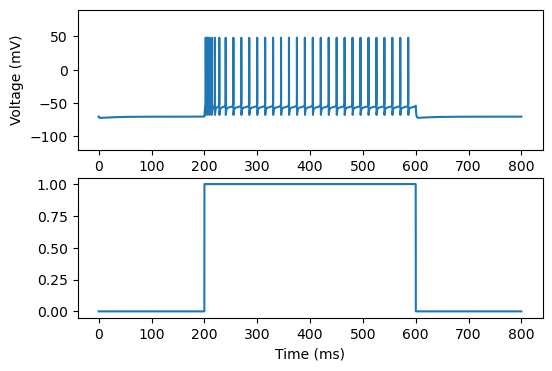

In [218]:
plt.figure(1,  figsize=(6, 4))
ax = plt.subplot(211)
_ = ax.plot(time_vec, s.T[:-1])
_ = ax.set_ylim([-120, 90])
_ = ax.set_xlabel("Time (ms)")
_ = ax.set_ylabel("Voltage (mV)")


ax = plt.subplot(212)
ax.plot(time_vec,stims[0].current)
_ = ax.set_xlabel("Time (ms)")
